In [1]:
import numpy as np
from matplotlib import pyplot as plt
from tqdm import tqdm
from ipywidgets import interact, IntSlider

## Monotone Schemes vs. Consistent Schemes

Consider the following PDE:

$$
    \begin{cases}
        u_t + cu_x=0,\text{ in } \R_{+}\times\R,
        \\
        u(0, x) = g(x).
    \end{cases}
$$

We have several options for the discretization. Let's test them all, assuming that $c$ is strictly positive.

Some explicit solutions:

1. $g(x) = \sin(x)\rightarrow u(t, x) = \sin(x-ct).$

**Forward Difference:**

$$
\frac{u^{n+1}_j-u^{n}_j}{\Delta t} + c\frac{u^{n}_{j+1}-u^{n}_{j}}{\Delta x}=0.
$$


Rewriting it, we get  
$$
u^{n+1}_j = u^n_j - \frac{c\Delta t}{\Delta x} \left(u^n_{j+1}-u^n_j\right).
$$

Defining  $\rho = \frac{c \Delta t}{\Delta x} $, we obtain the matrix equation:
$$
u^{n+1} = A u^n,
$$
where the matrix $A$ for periodic boundary conditions is:
$$
A =
\begin{bmatrix}
1 + \rho & -\rho & 0 & \cdots & 0 \\
0 & 1 + \rho &  & \cdots & 0 \\
\vdots & \ddots & \ddots & \ddots & \vdots \\
0 & \cdots & 0 & 1 + \rho & -\rho\\
-\rho & 0 & \cdots & 0 & 1 + \rho
\end{bmatrix}.
$$

This corresponds to the **explicit scheme** (valid for $c>0$) with periodic boundary conditions, advancing the solution via  
$$
u^{n+1} = A u^n.
$$

In [2]:
def step_forward(u, b, dt, dx):
    rho = b * dt / dx
    N = len(u)
    
    main_diag = (1 + rho) * np.ones(N)
    upper_diag = -rho * np.ones(N - 1)
    
    A = np.diag(main_diag) + np.diag(upper_diag, k=1)
    A[-1, 0] = -rho  # periodic BC

    return A @ u

**Backward Difference:**

$$
\frac{u^{n+1}_j-u^{n}_j}{\Delta t} + c\frac{u^{n}_{j}-u^{n}_{j-1}}{\Delta x}=0.
$$

In [3]:
def step_backward(u, b, dt, dx):
    rho = b * dt / dx
    N = len(u)
    
    main_diag = (1 - rho) * np.ones(N)
    lower_diag = rho * np.ones(N - 1)

    A = np.diag(main_diag) + np.diag(lower_diag, k=-1)
    A[0, -1] = rho 

    u_next = A @ u
    return u_next

**Central Difference**
$$
\frac{u^{n+1}_j-u^{n}_j}{\Delta t} + c\frac{u^{n}_{j+1}-u^{n}_{j-1}}{2\Delta x}=0.
$$

In [4]:
def step_central(u, b, dt, dx):
    N = len(u)
    rho = b * dt / (2 * dx)

    upper_diag = -rho * np.ones(N - 1)
    lower_diag = rho * np.ones(N - 1)

    D = np.diag(upper_diag, k=1) + np.diag(lower_diag, k=-1)
    D[0, -1] = rho      # periodic BC
    D[-1, 0] = -rho     # periodic BC

    A = np.eye(N) + D

    return A @ u

**Visualization**

In [ ]:
c = 1
a = -np.pi
b = np.pi
T = 1

def g(x):
    return np.sin(x)

def simulate(N_x=100, N_t=100, N=50):
    if N > N_t:
        raise("N must be less than N_t")
    x = np.linspace(a, b, N_x)
    dx = (b - a) / (N_x - 1)
    dt = T / N_t

    # u_forward = np.zeros((N_t, N_x))
    u_backward = np.zeros((N_t, N_x))
    u_central = np.zeros((N_t, N_x))

    # u_forward[0, :] = g(x)
    u_backward[0, :] = g(x)
    u_central[0, :] = g(x)

    for n in range(1, N_t):
        # u_forward[n, :] = step_forward(u_forward[n-1, :], c, dt, dx)
        u_backward[n, :] = step_backward(u_backward[n-1, :], c, dt, dx)
        u_central[n, :] = step_central(u_central[n-1, :], c, dt, dx)

    cfl = np.abs(c * dt / dx)
    plt.figure(figsize=(10, 6))
    # plt.plot(x, u_forward[N-1, :], label='Forward', color='blue')
    plt.plot(x, u_central[N-1, :], label='Central', color='violet')
    plt.plot(x, u_backward[N-1, :], label='Backward', color='magenta')
    plt.plot(x, np.sin(x - c * T), label='True', linestyle='dashed')
    plt.text(0.95, 0.95, f'CFL = {cfl:.2f}', ha='right', va='top',
            transform=plt.gca().transAxes, fontsize=12, bbox=dict(facecolor='white', alpha=0.6))
    plt.title('Transport Equation')
    plt.xlabel('x')
    plt.ylabel('u')
    plt.legend()
    plt.grid(True)
    plt.show()

interact(simulate,
         N_x=IntSlider(min=20, max=200, step=10, value=100, description='N_x'),
         N_t=IntSlider(min=10, max=300, step=10, value=100, description='N_t'),
         N=IntSlider(min=10, max=300, step=1, value=50, description='t / N_t'))

interactive(children=(IntSlider(value=100, description='N_x', max=200, min=20, step=10), IntSlider(value=100, …

<function __main__.simulate(N_x=100, N_t=100, N=50)>

---

## American Options

Black--Scholes equation with continuous dividends $q$:
$$
\frac{\partial V}{\partial t} + \frac{1}{2} \sigma^2 S^2 \frac{\partial^2 V}{\partial S^2} + (r - q) S \frac{\partial V}{\partial S} - r V = 0
$$

Obstacle equation for the price of an American Call Option:
$$
\min\left\{
\frac{\partial V}{\partial t} + \frac{1}{2} \sigma^2 S^2 \frac{\partial^2 V}{\partial S^2} + (r - q) S \frac{\partial V}{\partial S} - r V,\, 
V - (S - K)^+
\right\} = 0
$$

with terminal condition:
$$
V(T, S) = (S - K)^+
$$

In [6]:
from black_scholes import BS_CALL, BS_PUT
from model import Model, Slice
import numpy.typing as npt

In [7]:
def European_Call(model: Model,
                 K: np.float64) -> np.ndarray[np.float64]:
    
    uOption = Slice(model)
    # itime = uOption.iTime

    uOption.current_price = np.maximum(0, uOption.current_price - K)
    
    uOption.rollback(0)
        
    return uOption.current_price

def European_Put(model: Model,
                 K: np.float64) -> np.ndarray[np.float64]:
    
    uOption = Slice(model)
    # itime = uOption.iTime

    uOption.current_price = np.maximum(0, K - uOption.current_price)
    
    uOption.rollback(0)
        
    return uOption.current_price

def American_Call(model: Model,
                 K: np.float64) -> np.ndarray[np.float64]:
    
    uOption = Slice(model)
    time = uOption.iTime
    
    uOption.current_price = np.maximum(0, uOption.current_price - K)
    exp_price = np.maximum(model.stock_grid - K, 0)
    
    while time > 0:
        
        uOption.current_price = np.maximum(exp_price, uOption.current_price)
        
        uOption.rollback(time - 1)
        
        time -= 1
     
    return uOption.current_price

def American_Put(model: Model,
                 K: np.float64) -> np.ndarray[np.float64]:
    
    uOption = Slice(model)
    time = uOption.iTime
    
    uOption.current_price = np.maximum(0, K - uOption.current_price)
    exp_price = np.maximum(K - model.stock_grid, 0)
    
    while time > 0:
        
        uOption.current_price = np.maximum(exp_price, uOption.current_price)
        
        uOption.rollback(time - 1)
        
        time -= 1
     
    return uOption.current_price

In [8]:
def r(times: npt.NDArray) -> npt.NDArray:
    
    return 0.02 * np.ones(times.shape, dtype='float')

def q(times: npt.NDArray) -> npt.NDArray:
    
    return 0.015 * np.ones(times.shape, dtype='float')

def sigma(times: npt.NDArray) -> npt.NDArray:
    
    return 0.15 * np.ones(times.shape, dtype='float')


bs_model = Model(r,
                 q,
                 sigma,
                 S_min = -10,
                 S_max = 300,
                 N_steps = 500,
                 times = np.linspace(0, 1, 800))

In [9]:
def r_for_american(times: npt.NDArray) -> npt.NDArray:
    """discount for american option"""
    
    return 0.1 * np.ones(times.shape, dtype='float')

def q_for_american(times: npt.NDArray) -> npt.NDArray:
    """dividend yield for american option"""
    
    return 0.09 * np.ones(times.shape, dtype='float')


bs_model_for_american = Model(r_for_american,
                 q_for_american,
                 sigma,
                 S_min = -10,
                 S_max = 300,
                 N_steps = 500,
                 times = np.linspace(0, 1, 800))

### European Call

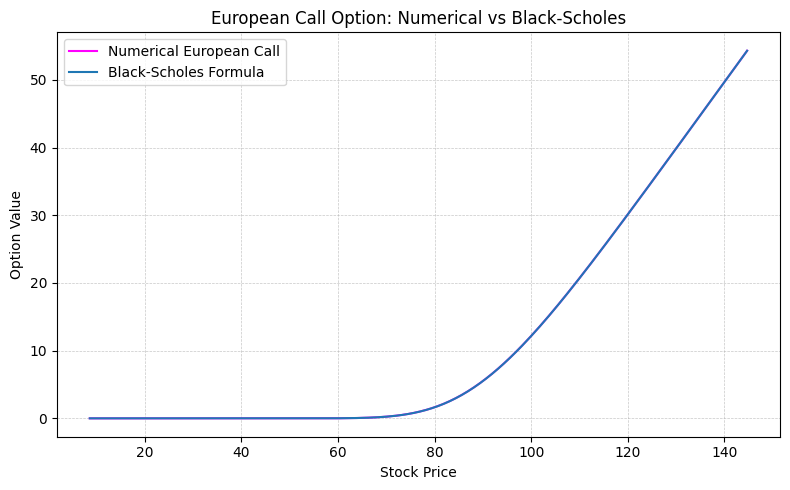

In [10]:
plt.figure(figsize=(8, 5))

plt.plot(bs_model.stock_grid[30:250],
         European_Call(bs_model, 90)[30:250],
         color="magenta",
         label="Numerical European Call")

bs = BS_CALL(bs_model.stock_grid[30:250], 90, 1, 0.02, 0.015, 0.15)
plt.plot(bs_model.stock_grid[30:250], bs, label="Black-Scholes Formula")

plt.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.7)
plt.xlabel("Stock Price")
plt.ylabel("Option Value")
plt.title("European Call Option: Numerical vs Black-Scholes")
plt.legend()
plt.tight_layout()
plt.show()

### American Call vs. European Call

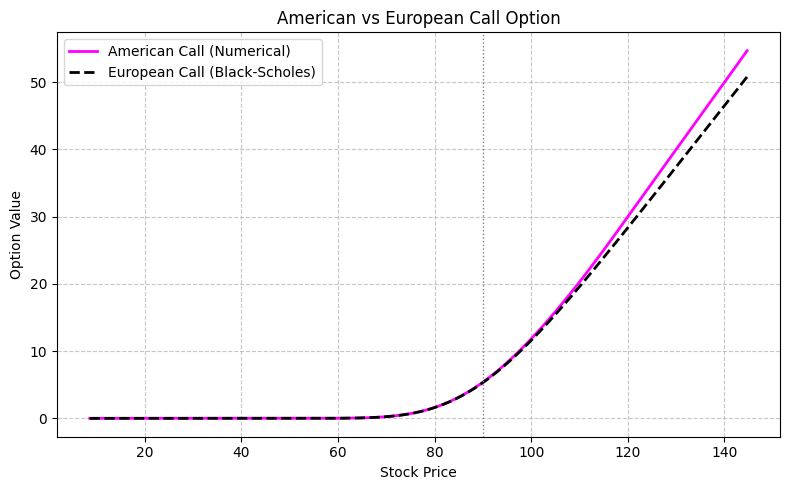

In [11]:
plt.figure(figsize=(8, 5))

plt.plot(bs_model_for_american.stock_grid[30:250], 
         American_Call(bs_model_for_american, 90)[30:250], 
         color="magenta", 
         linewidth=2, 
         label="American Call (Numerical)")

bs = BS_CALL(bs_model.stock_grid[30:250], 90, 1, 0.1, 0.09, 0.15)
plt.plot(bs_model_for_american.stock_grid[30:250], 
         bs, 
         color="black", 
         linestyle="--", 
         linewidth=2,
         label="European Call (Black-Scholes)")

plt.axvline(x=90, color='gray', linestyle=':', linewidth=1)

plt.title("American vs European Call Option")
plt.xlabel("Stock Price")
plt.ylabel("Option Value")
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()
plt.tight_layout()
plt.show()

### American Put

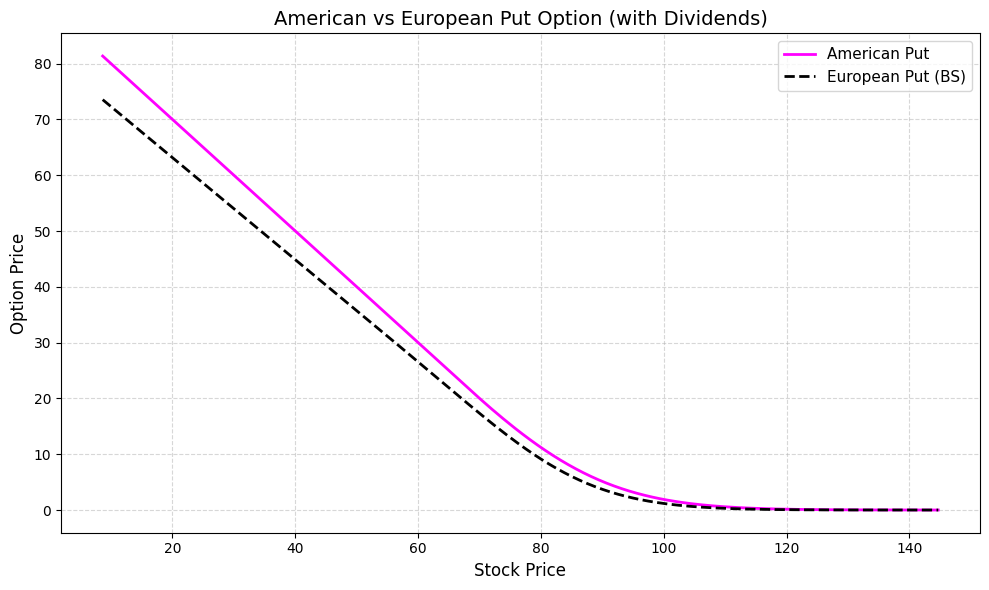

In [12]:
plt.figure(figsize=(10, 6))

plt.plot(bs_model_for_american.stock_grid[30:250], 
         American_Put(bs_model, 90)[30:250], 
         color="magenta", 
         linestyle='-', 
         linewidth=2,
         label="American Put")

bs = BS_PUT(bs_model.stock_grid[30:250], 90, 1, 0.1, 0.09, 0.15)
plt.plot(bs_model.stock_grid[30:250], 
         bs, 
         color="black", 
         linestyle='--', 
         linewidth=2,
         label="European Put (BS)")

plt.title("American vs European Put Option (with Dividends)", fontsize=14)
plt.xlabel("Stock Price", fontsize=12)
plt.ylabel("Option Price", fontsize=12)
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend(loc="best", fontsize=11)

plt.tight_layout()
plt.show()